In [1]:
# code taken from https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/

In [2]:
n = 9 # number of decimal places to keep

In [3]:
from pandas import read_csv
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import json

In [4]:
def zanh(x):
    return 0.006769816 + 0.554670504 * x - 0.009411195 * x**2 - 0.014187547 * x**3

def zanh_int(x, n):
    return 554670504 * x * 10**(2*n) - 9411195 * x**2 * 10**n - 14187547 * x**3 + 6769816 * 10**(3*n)

Epoch 1/20


2023-10-13 00:07:28.409763: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


187/187 - 1s - loss: 0.0511 - 546ms/epoch - 3ms/step
Epoch 2/20
187/187 - 0s - loss: 0.0279 - 140ms/epoch - 747us/step
Epoch 3/20
187/187 - 0s - loss: 0.0227 - 141ms/epoch - 752us/step
Epoch 4/20
187/187 - 0s - loss: 0.0183 - 142ms/epoch - 758us/step
Epoch 5/20
187/187 - 0s - loss: 0.0128 - 139ms/epoch - 744us/step
Epoch 6/20
187/187 - 0s - loss: 0.0072 - 143ms/epoch - 765us/step
Epoch 7/20
187/187 - 0s - loss: 0.0051 - 142ms/epoch - 760us/step
Epoch 8/20
187/187 - 0s - loss: 0.0047 - 143ms/epoch - 765us/step
Epoch 9/20
187/187 - 0s - loss: 0.0047 - 140ms/epoch - 750us/step
Epoch 10/20
187/187 - 0s - loss: 0.0047 - 146ms/epoch - 779us/step
Epoch 11/20
187/187 - 0s - loss: 0.0044 - 144ms/epoch - 772us/step
Epoch 12/20
187/187 - 0s - loss: 0.0045 - 143ms/epoch - 763us/step
Epoch 13/20
187/187 - 0s - loss: 0.0042 - 144ms/epoch - 769us/step
Epoch 14/20
187/187 - 0s - loss: 0.0043 - 147ms/epoch - 788us/step
Epoch 15/20
187/187 - 0s - loss: 0.0041 - 149ms/epoch - 799us/step
Epoch 16/20
187/1

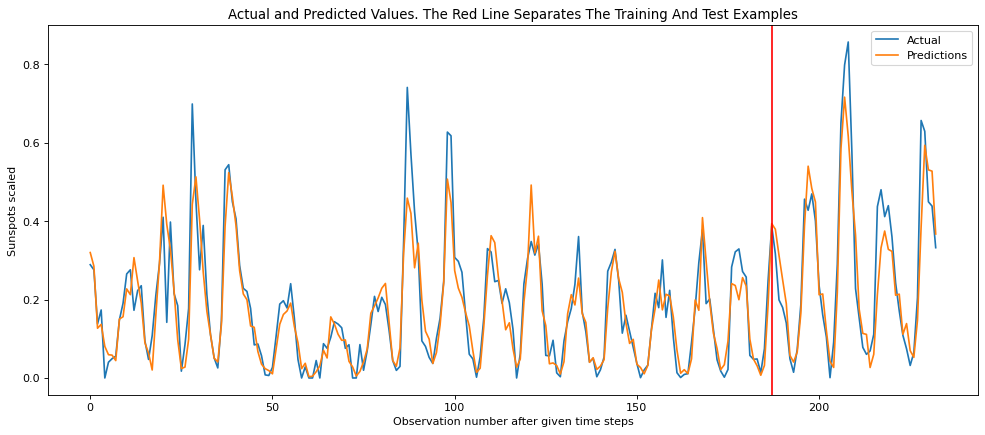

In [5]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    

# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
time_steps = 12
train_data, test_data, data = get_train_test(sunspots_url)
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Create model and train
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=[zanh, zanh])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Print error
print_error(trainY, testY, train_predict, test_predict)

#Plot result
plot_result(trainY, testY, train_predict, test_predict)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 15        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [7]:
wx = (model.get_weights()[0]*float(10**n)).round().astype(int)
wh = (model.get_weights()[1]*float(10**n)).round().astype(int)
bh = (model.get_weights()[2]*float(10**(2*n))).round().astype(int)
wy = model.get_weights()[3]
by = model.get_weights()[4]

print('wx = ', wx, ' wh = ', wh, ' bh = ', bh, ' wy =', wy, 'by = ', by)

wx =  [[1151000960  198489440  -88292616]]  wh =  [[ -136684976  -181618384 -1191004800]
 [ -766409024   640444160   170032992]
 [ -627080896 -1067461120  1166566144]]  bh =  [-166064584082325504  101810017908293632  -75451691943591936]  wy = [[ 0.18589276]
 [ 1.1632138 ]
 [-0.5340174 ]] by =  [0.09409621]


In [8]:
X = (testX[0]*float(10**n)).round().astype(int)
print('X = ', X)

X =  [[522064576]
 [506304160]
 [330575264]
 [430654048]
 [459810816]
 [513396384]
 [571710016]
 [542553152]
 [396769088]
 [492119744]
 [293144192]
 [349881792]]


In [9]:
h = [np.zeros(3).astype(int)]
matmul_out = []
matmul_remainder = []
zanh_out = []
zanh_remainder = []
for i in range(12):
    H = np.dot(X[i], wx) + np.matmul(h[-1],wh) + bh
    # print('H = ', H)
    mo = H // 10**n
    mr = H - mo * (10**n)
    print('mo = ', mo, ' mr = ', mr)


    zh = [zanh_int(om, n) for om in mo.astype(int).flatten().tolist()]
    # print('zh = ', zh)
    zo = [hz // 10**(3*n) for hz in zh]
    zr = [str(hz - oz * (10**(3*n))) for hz, oz in zip(zh, zo)]
    zo = np.array(zo)
    print('zh = ', zh, ' zo = ', zo, ' zr = ', zr)

    h.append(zo)
    matmul_out.append(mo.astype(str).flatten().tolist())
    matmul_remainder.append(mr.astype(str).flatten().tolist())
    zanh_out.append(zo.astype(str).flatten().tolist())
    zanh_remainder.append(zr)

with open('matmul_out.json', 'w') as f:
    json.dump(matmul_out , f)

with open('matmul_remainder.json', 'w') as f:
    json.dump(matmul_remainder , f)

with open('zanh_out.json', 'w') as f:
    json.dump(zanh_out , f)

with open('zanh_remainder.json', 'w') as f:
    json.dump(zanh_remainder , f)

mo =  [ 434832244  205434323 -121546140]  mr =  [ 75667456 242371072 920437248]
zh =  [245012508627603455472533643802009152, 120197986348474730245133438266292951, -60761802709216205029881033005432000]  zo =  [245012508 120197986 -60761803]  zr =  ['627603455472533643802009152', '348474730245133438266292951', '290783794970118966994568000']
mo =  [ 329184206  299648231 -462410723]  mr =  [ 84778112 794678080 154043584]
zh =  [187832681312751298608904125135050648, 171749111088094600103903252677499123, -250325324455690588405974261442593351]  zo =  [ 187832681  171749111 -250325325]  zr =  ['312751298608904125135050648', '88094600103903252677499123', '544309411594025738557406649']
mo =  [ 214098117  510520115 -591166706]  mr =  [197540816 865904048 630961952]
zh =  [124953101892236575159159896686684689, 285599662195332898025451844607456375, -321490780669373647332439387786380648]  zo =  [ 124953101  285599662 -321490781]  zr =  ['892236575159159896686684689', '195332898025451844607456375', '

In [10]:
y = model.predict(testX[[0]])
o12 = zanh(np.dot(h[-1]/(10**n), wy) + by)
print(y, o12)

1/1 [==============================] - 0s 14ms/step
[[0.39366245]] [0.39366249]


In [11]:
# quantization
params_json = {
    'wx': wx.round().astype(int).astype(str).flatten().tolist(),
    'wh': wh.round().astype(int).astype(str).flatten().tolist(),
    'b': bh.round().astype(int).astype(str).flatten().tolist()
}

In [12]:
with open('params.json', 'w') as f:
    json.dump(params_json, f)

In [13]:
with open("in.json", "w") as f:
    json.dump(X.round().astype(int).astype(str).flatten().tolist(), f)